In [1]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
from collections import defaultdict
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
import csv

In [2]:
# create dictionary of terms with valence, arousal, and dominance rankings

file_name = '/joy/joyData/WordRankings/NRC-VAD-Lexicon.txt'
emoji_file = '/joy/joyData/WordRankings/EmojiIntensity.csv'

terms = {}
va = []
ar = []
do = []
counter=0 

# read words file and store valence, arousal, and dominance in a dictionary
with open(file_name, 'r') as f:
    lines=f.readlines()
    
    for row in lines:
        row_=row.split("\t")
        try:
            terms[row_[0]] = counter
            va.append(float(row_[1]))
            ar.append(float(row_[2]))
            do.append(float(row_[3]))
            counter +=1
        except:
            print(row_)

            
# read emojis file and store arousal and dominance values
with open(emoji_file) as g:
      
    emoji_data = csv.reader(g)
      
    for row in emoji_data:
        if row[1] != "Char" and row[7] != "Emot_Intensity":
            terms[row[1]] = counter
            va.append(0)
            ar.append(float(row[7]))
            do.append(float(row[7]))
            counter += 1



In [3]:
df = pd.read_csv('/joy/joyData/allData')

count_vectorizer = CountVectorizer(vocabulary=terms, ngram_range=(1,2))
count_vectors = count_vectorizer.fit_transform(df['clean_tweet'].values.astype('U')).toarray()

tfidf_vectorizer = TfidfVectorizer(vocabulary=terms, ngram_range=(1,2))
tfidf_vectors = tfidf_vectorizer.fit_transform(df['clean_tweet'].values.astype('U')).toarray()

In [4]:
def remove_zeros(vectors):
    
    #print the shape of the original matrix
    print("original matrix size", vectors.shape)

    #mark all-zero columns
    mask = (vectors == 0).all(0)

    # Find the indices of these columns (we might need those)
    column_indices = np.where(mask)[0]

    # Update vectors to only include the columns where non-zero values occur.
    vectors = vectors[:,~mask]

    #print the shape of the new vector matrix
    print("compact matrix size", vectors.shape)
    
    return vectors


In [5]:
def do_pca(vectors):

    # PCA
    pca = PCA(2)
    pca.fit(vectors)
    docs_pca = pca.transform(vectors)

    plt.figure(figsize = (8, 8))
    plt.grid()
    
    sns.scatterplot(x=docs_pca[:, 0], y = docs_pca[:, 1], hue=df['ijoy'])
    plt.show()
    #plt.savefig('Word Freq.png') 

In [6]:
# transfrom weights and add one to each value
ar  = np.array(ar)+1
do  = np.array(do)+1
va  = np.array(va)+1

# create weighted vectors
va_vectors= remove_zeros(tfidf_vectors*va)
ar_vectors= remove_zeros(tfidf_vectors*ar)
do_vectors= remove_zeros(tfidf_vectors*do)

original matrix size (18226, 20722)
compact matrix size (18226, 8536)
original matrix size (18226, 20722)
compact matrix size (18226, 8536)
original matrix size (18226, 20722)
compact matrix size (18226, 8536)


original matrix size (18226, 20722)
compact matrix size (18226, 8536)
original matrix size (18226, 20722)
compact matrix size (18226, 8536)


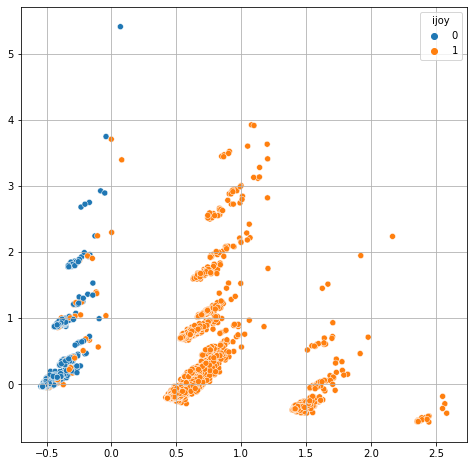

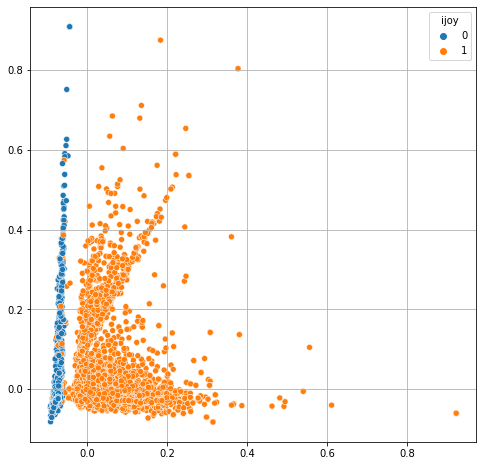

In [7]:
# remove zeros from vectors
count_vectors = remove_zeros(count_vectors)
tfidf_vectors = remove_zeros(tfidf_vectors)

# compare tfidf and count vectorizers
do_pca(count_vectors)
do_pca(tfidf_vectors)

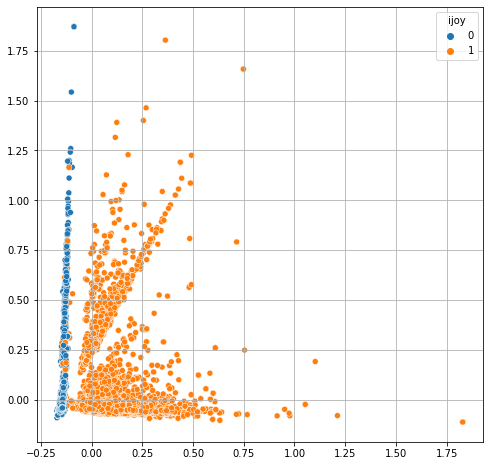

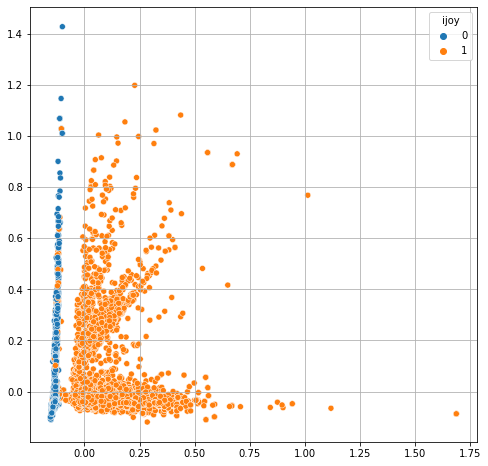

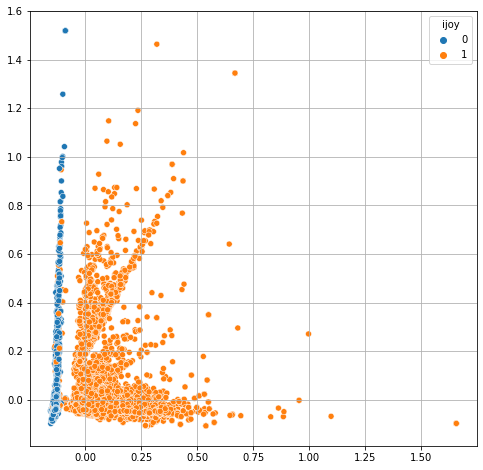

In [7]:
# PCA weighted for valence, arousal, and dominance
do_pca(va_vectors)
do_pca(ar_vectors)
do_pca(do_vectors)

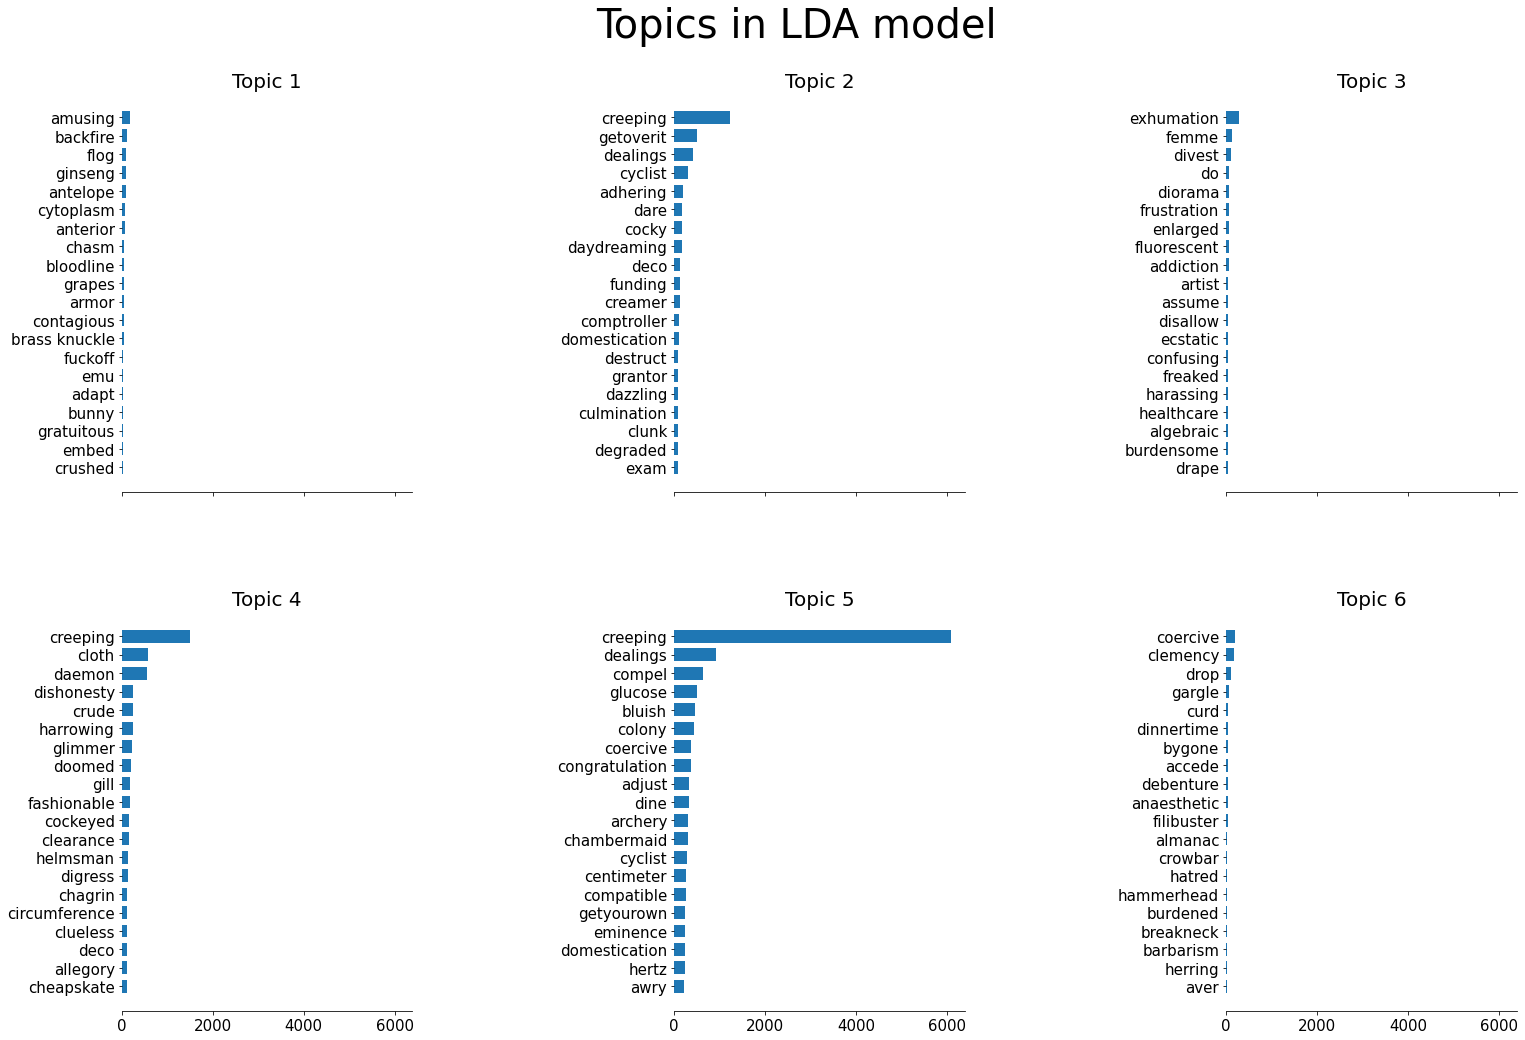

In [11]:
# topic modeling on valence vectors using count vectorizer
# should probably do separate topic modeling for joy and no joy tweets?

lda_model = LatentDirichletAllocation(
    n_components = 6,
    max_iter = 10,
    learning_method = 'online',
    learning_offset = 50,
    random_state = 32
)
lda_vectors = lda_model.fit(va_vectors)

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize = (25, 15), sharex = True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1: -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    #plt.savefig('JoyTopics.png')
    
n_top_words = 20
count_feature_names = count_vectorizer.get_feature_names_out()

plot_top_words(lda_model, count_feature_names, n_top_words, "Topics in LDA model")

In [12]:
# count the number of features in the tweets that also appear in the valence/arousal dataset
vectorizer2 = CountVectorizer()
vectors = vectorizer2.fit_transform(df['clean_tweet'].values.astype('U'))
data_features = vectorizer2.get_feature_names_out()

count = 0
for word in data_features:
    if word in terms.keys():
        count += 1

# return as a percentage
print(count/len(data_features))

# count each occurrence of a word from the valence/arousal dataset in the tweets
all_tweets = ""
for tweet in df['clean_tweet']:
    all_tweets += str(tweet)
    all_tweets += " "
 
count2 = 0
for word in all_tweets.split(" "):
    if word in terms.keys():
        count2 += 1

# return as a percentage
print(count2/len(all_tweets.split(" ")))

0.20351605420583568
0.512655710349645


In [13]:
# check percentage of emojis in the data that are face emojis
face_emojis = 0
other_emojis = 0
for emojis in df['emoji_meanings']:
    emojis = emojis.strip('[')
    emojis = emojis.strip(']')
    emojis = emojis.strip("'")
    emojis = emojis.split(', ')
    if len(emojis) != 0:
        for emoji in value:
            
        for meaning in emojis:
            if "face" in meaning:
                face_emojis += 1
            else:
                other_emojis += 1

total = face_emojis + other_emojis
print(face_emojis/total)
print(other_emojis/total)
print(total)


0.15587915845367875
0.8441208415463213
24859


In [8]:
import emot

emot_obj = emot.core.emot()

emojis_count = 0
included_emojis = []

for tweet in df['clean_tweet']:  
    emojis = emot_obj.emoji(tweet) 
    for emoji in emojis['value']:
        if emoji in terms.keys():
            emojis_count += 1
            if emoji not in included_emojis:
                included_emojis.append(emoji)
    
# total number of times an emoji in the dataset was used in a tweet
print(emojis_count)
# number of unique emojis that show up in both datasets
# 183 actually recognized and contain nonzeros in the vectors
print(len(included_emojis))
# list of emojis in the dataset included in the tweets
print(included_emojis)

7841
383
['😎', '💞', '💙', '🐻', '⬇', '😢', '😭', '💀', '👊', '✨', '💜', '💕', '❤', '🎶', '🌈', '💥', '🎂', '🌒', '🌓', '🌔', '🌙', '🌹', '📷', '😮', '🏁', '😁', '🏈', '😍', '😘', '👏', '👍', '😃', '🍅', '😋', '😊', '🌺', '🐝', '🌱', '👶', '🍼', '🔥', '🍺', '❗', '😅', '😂', '🎁', '🍁', '🙏', '👎', '😏', '🏆', '👑', '💃', '🙌', '😀', '😫', '🌞', '😬', '🌟', '💖', '👗', '😉', '😱', '😔', '⚡', '🍯', '🍎', '💯', '💋', '💔', '⏳', '☺', '👀', '💪', '🍀', '🍑', '😪', '🚨', '🚀', '😒', '😳', '📻', '😈', '☀', '🙊', '💤', '🌻', '😹', '😑', '😝', '💉', '☹', '😌', '🎃', '😡', '♥', '😥', '▪', '🌿', '😩', '💦', '🎈', '🎊', '🎉', '💝', '📖', '⚽', '😓', '🌸', '⛄', '☕', '🎼', '🎹', '🎸', '😻', '🎡', '💗', '💫', '🌎', '🍻', '🍷', '🍹', '®', '📚', '🍰', '😤', '✌', '🐈', '💛', '🌳', '🌲', '🎭', '😇', '❄', '🎥', '🌊', '👻', '✔', '💎', '🔒', '🐖', '😕', '🐲', '🏉', '💩', '🍊', '👌', '😶', '🐧', '🐼', '🐶', '🐱', '💒', '💚', '💍', '🎀', '😛', '🍆', '😠', '☮', '🙀', '🐂', '🍚', '🍛', '⭐', '💐', '🆓', '⬅', '⬆', '🍂', '👫', '💌', '🏀', '🚬', '🗽', '✅', '😄', '✏', '✈', '😴', '💓', '♌', '🍒', '🎧', '🍃', '👉', '🌚', '😆', '😞', '🐘', '⚪', '🍪', '🍫', '🍭', '🎄', '🎅', '☝', '😜', 